# 03 Start exploring the datasets 

> Initial exploration of the data   

In [1]:
#|default_exp core.03_explore_datasets

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model

import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

---

In [6]:
# Load the datasets with Local Authority District demographic info 
df_lad_age_21 = pd.read_csv(const.output_path+'/LAD_age_2021.csv')
df_lad_ethn_21 = pd.read_csv(const.output_path+'/LAD_ethnicity_percent_2021.csv')
df_lad_educ_21 = pd.read_csv(const.output_path+'/LAD_education_2021.csv')

# And the ADI health dataset
df_ADI_health_21 = pd.read_csv(const.data_path+'/ADI_data/ADI_health_2021.csv')

In [7]:
df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted']].head()

,area_code,area_name,pop,DEM_afflicted
0,E07000091,New Forest,151481,1858.546949
1,E09000027,Richmond upon Thames,156795,1016.262785
2,E07000116,Tunbridge Wells,95022,876.255260
3,E07000121,Lancaster,123214,1228.376774
4,E07000042,Mid Devon,67987,547.793487


In [8]:
print(f'Number of LADs in the ADI dataset: {len(df_ADI_health_21)}. Number of LADs in the demographic dataset: {len(df_lad_age_21)}.')

Number of LADs in the ADI dataset: 309. Number of LADs in the demographic dataset: 331.


In [9]:
# Fix the mismatch in LADs resulting from the inclusion of Welsh LADs - poor old Wales :(
wales_LAD = list(df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_ADI_health_21['area_name'])]['LAD_name'])

# Drop all the LADs in Wales from datasets 
df_lad_age_21.drop(df_lad_age_21[df_lad_age_21['LAD_name'].isin(wales_LAD)].index, inplace=True)
df_lad_educ_21.drop(df_lad_educ_21[df_lad_educ_21['Area name'].isin(wales_LAD)].index, inplace=True)
df_lad_ethn_21.drop(df_lad_ethn_21[df_lad_ethn_21['Area name'].isin(wales_LAD)].index, inplace=True)

Now a little bit of processing to merge categories and get an informative percent. For covariates I'm looking at:
* percent of the population over 65
* percent of the population with A-level or higher qualifications 
* percent of the population who have white ethnicity 

In [10]:
df_lad_educ_21['ALevel_plus'] = df_lad_educ_21['level 3: a-level']+df_lad_educ_21['level 4: bsc']

Also want to look at the health conditions which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)

Could also consider:
- Depression (DEP)
- Parkinsonism - not in the QOF dataset - I suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [11]:
# merge the datasets into one 
df_dem_educ = pd.merge(df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']], df_lad_educ_21[['Area name', 'ALevel_plus']], left_on='area_name', right_on='Area name')
df_dem_educ_age = pd.merge(df_dem_educ, df_lad_age_21, left_on='area_name', right_on='LAD_name')
df_dem_covar =  pd.merge(df_dem_educ_age, df_lad_ethn_21[["Area name","White: English, Welsh, Scottish, Northern Irish or British\n(percent)"]], left_on='area_name', right_on='Area name')

# rename long col name
df_dem_covar.rename(axis=1, mapper={'White: English, Welsh, Scottish, Northern Irish or British\n(percent)':'white_pc'}, inplace=True)

# drop some duplicated columns 
df_dem_covar.drop(axis=1, labels=['Area name_x', 'Area name_y', 'LAD_name'], inplace=True)

In [12]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,white_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,93.2
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,63.0
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,84.2
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,87.8
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,93.8


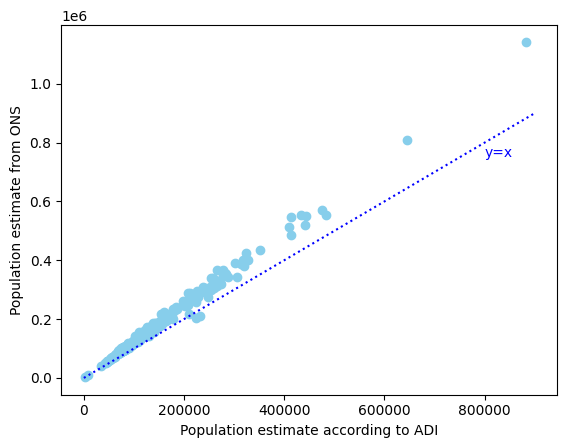

In [13]:
plt.scatter(df_dem_covar['pop'], df_dem_covar['all_age'], color = 'skyblue')
plt.plot(np.arange(900000), np.arange(900000), ':', color='b')
plt.text(800000, 750000, r'y=x', fontsize=10, color='b')
plt.xlabel('Population estimate according to ADI')
plt.ylabel('Population estimate from ONS')
plt.show()

In [14]:
# create dataframe columns with percentages 
df_dem_covar['DEM_afflicted_pc'] = df_dem_covar['DEM_afflicted']/df_dem_covar['pop']
df_dem_covar['ALevel_plus_pc'] =  df_dem_covar['ALevel_plus']/df_dem_covar['pop']
df_dem_covar['over_65_pc'] = df_dem_covar['over_65']/df_dem_covar['pop']
df_dem_covar['female_pc'] = df_dem_covar['Female_all']/df_dem_covar['pop']
df_dem_covar['white_pc'] = df_dem_covar['white_pc']/100

In [15]:
# and columns with disease prevalence for the comorbidities of hypertension (HYP), diabetes (DM) and stroke (STIA)
df_dem_covar['HYP_afflicted_pc'] = df_dem_covar['HYP_afflicted']/df_dem_covar['pop']
df_dem_covar['DM_afflicted_pc'] = df_dem_covar['DM_afflicted']/df_dem_covar['pop']
df_dem_covar['STIA_afflicted_pc'] = df_dem_covar['STIA_afflicted']/df_dem_covar['pop']

In [16]:
# save a .csv of `df_dem_covar`
df_dem_covar.to_csv(const.output_path+'/df_dem_plus.csv', index=False)

In [17]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,Male_over_65,over_65,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,23644.9796,51920.6826,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,14170.0187,31637.7606,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,10171.4566,22570.0090,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,13527.6316,29465.7648,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,9396.6343,20046.6806,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507


## Linear regression 
Plot the regression line as well as the residuals. The residual is the difference between an observed value, and the value predicted by the linear regression model.

Want to check that:
* There is a correlation in the regression model
* The residuals are randomly scattered
* The p-value of the independent variable is significant 

In [50]:
#|export 

def lin_reg_analysis(x,
                     y,
                     var_name:str):
    
    x = x.values.reshape(-1,1)
    y = y.values.reshape(-1,1)

    regr = linear_model.LinearRegression()

    # fit regression
    regr.fit(x, y)
    y_pred = regr.predict(x)

    # residuals 
    resid = y-y_pred

    plt.subplots(nrows=2, ncols= 1, figsize = (6,10))

    plt.subplot(2, 1, 1)
    plt.scatter(x, y, color='plum')
    plt.plot(x, y_pred, color='yellowgreen')
    plt.title('Linear Regression Model')
    plt.xlabel(f'% population {var_name}')
    plt.ylabel('% population dementia')

    plt.subplot(2, 1, 2)
    plt.scatter(x, resid, color='darkseagreen')
    plt.plot(x, np.zeros(len(x)), ':', color='lightblue')
    plt.title('Model Residuals')
    plt.ylabel('Residuals')
    plt.xlabel(f'% population {var_name}')

    x_sm = sm.add_constant(x)
    model = sm.OLS(y, x_sm).fit()

    print(f'Intercept:{regr.intercept_[0]}')
    print(f'-------- \nCoefficient \n{var_name}:{regr.coef_[0][0]}')
    print(f'-------- \np-value\n{var_name}:{model.pvalues[1]}')

Intercept:0.0003368375088725348
-------- 
Coefficient 
>65 years:0.030210141166536947
-------- 
p-value
>65 years:1.1738817306574228e-94


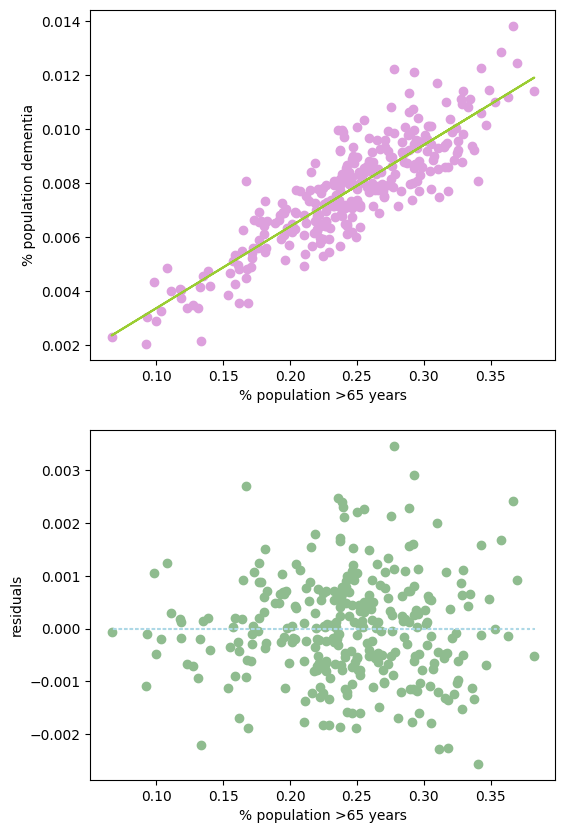

In [51]:
lin_reg_analysis(x=df_dem_covar['over_65_pc'], y=df_dem_covar['DEM_afflicted_pc'], var_name='>65 years')

Intercept:0.012758395983180742
-------- 
Coefficient 
> GCSE education:-0.009947499489368778
-------- 
p-value
> GCSE education:1.8029838952084162e-12


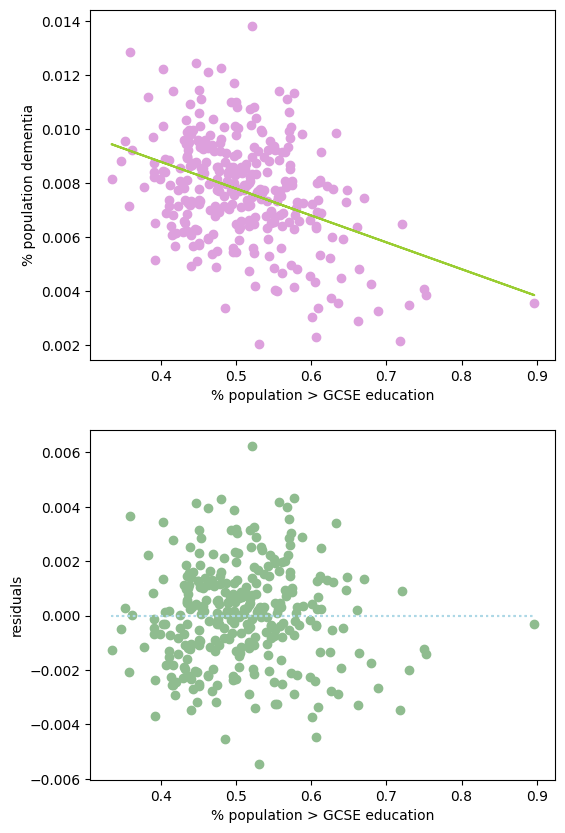

In [52]:
lin_reg_analysis(x=df_dem_covar['ALevel_plus_pc'], y=df_dem_covar['DEM_afflicted_pc'], var_name='> GCSE education')

Intercept:0.0014099892816864619
-------- 
Coefficient 
white ethnicity:0.008021799299977391
-------- 
p-value
white ethnicity:9.6711794202773e-59


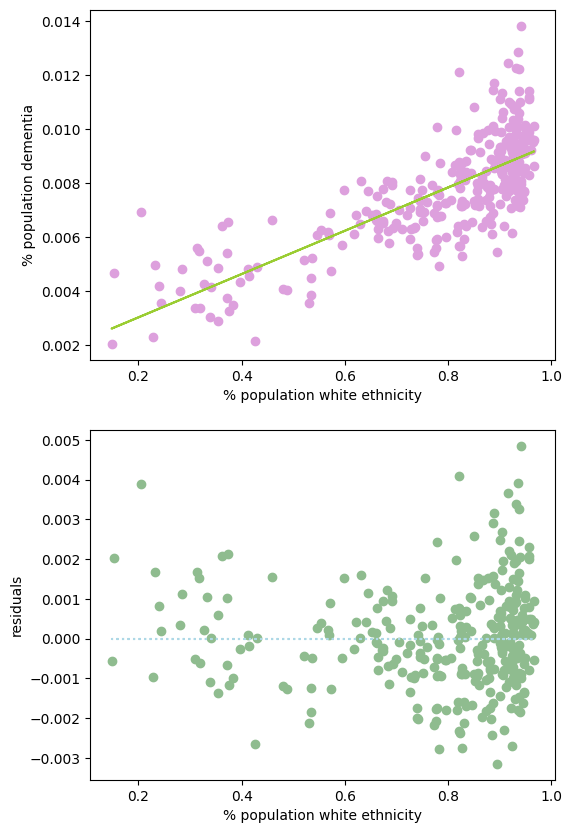

In [53]:
lin_reg_analysis(x=df_dem_covar['white_pc'], y=df_dem_covar['DEM_afflicted_pc'], var_name='white ethnicity')

Intercept:0.0014099892816864619
-------- 
Coefficient 
white ethnicity:0.008021799299977391
-------- 
p-value
white ethnicity:9.6711794202773e-59


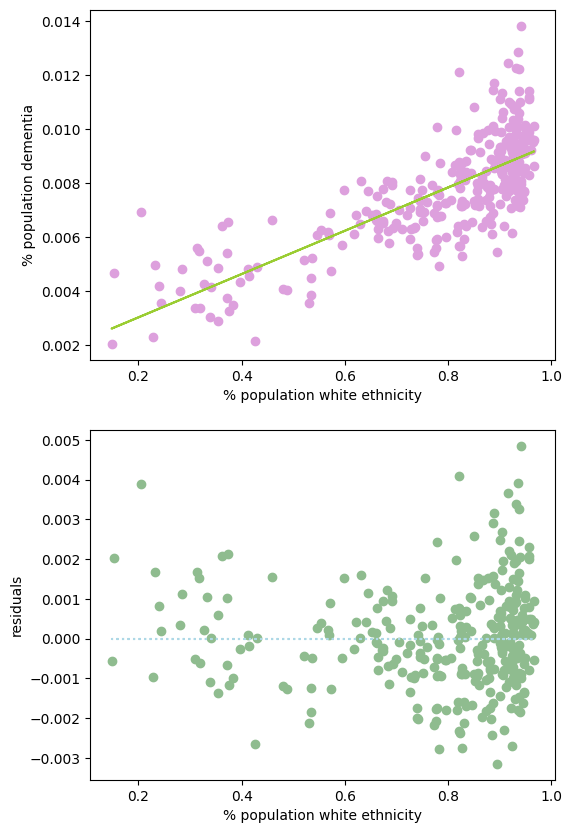

In [54]:
lin_reg_analysis(x=df_dem_covar['white_pc'], y=df_dem_covar['DEM_afflicted_pc'], var_name='white ethnicity')

Intercept:0.015732422899790544
-------- 
Coefficient 
female:-0.012749420402413565
-------- 
p-value
female:0.00024688370509666187


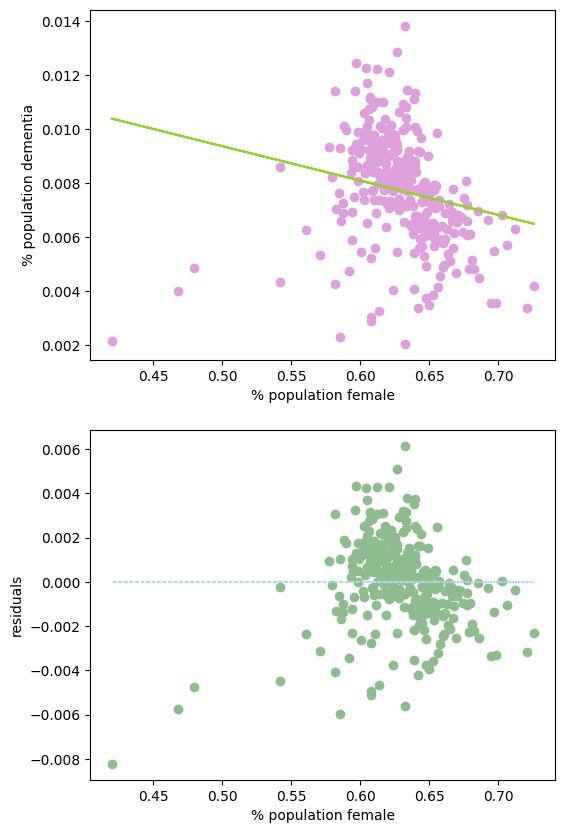

In [55]:
lin_reg_analysis(x=df_dem_covar['female_pc'], y=df_dem_covar['DEM_afflicted_pc'], var_name='female')

Now going to look at the health problems which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)
- Depression (DEP)

- Parkinsonism - not in the QOF dataset - suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [53]:
df_dem_covar.columns

Index(['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted',
       'DM_afflicted', 'STIA_afflicted', 'ALevel_plus', 'Female_all',
       'Male_all', 'all_age', 'Female_over_65', 'Male_over_65', 'over_65',
       'white_pc', 'DEM_afflicted_pc', 'ALevel_plus_pc', 'over_65_pc',
       'female_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc',
       'STIA_afflicted_pc'],
      dtype='object')

In [54]:
# label data for regression
x_hyp = df_dem_covar['HYP_afflicted_pc'].values.reshape(-1,1)
x_dm = df_dem_covar['DM_afflicted_pc'].values.reshape(-1,1)
x_stia = df_dem_covar['STIA_afflicted_pc'].values.reshape(-1,1)

y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities

# hypertension
regr.fit(x_hyp, y)
y_pred_hyp = regr.predict(x_hyp)

# diabetes 
regr.fit(x_dm, y)
y_pred_dm = regr.predict(x_dm)

# stroke (STIA)
regr.fit(x_stia, y)
y_pred_stia = regr.predict(x_stia)

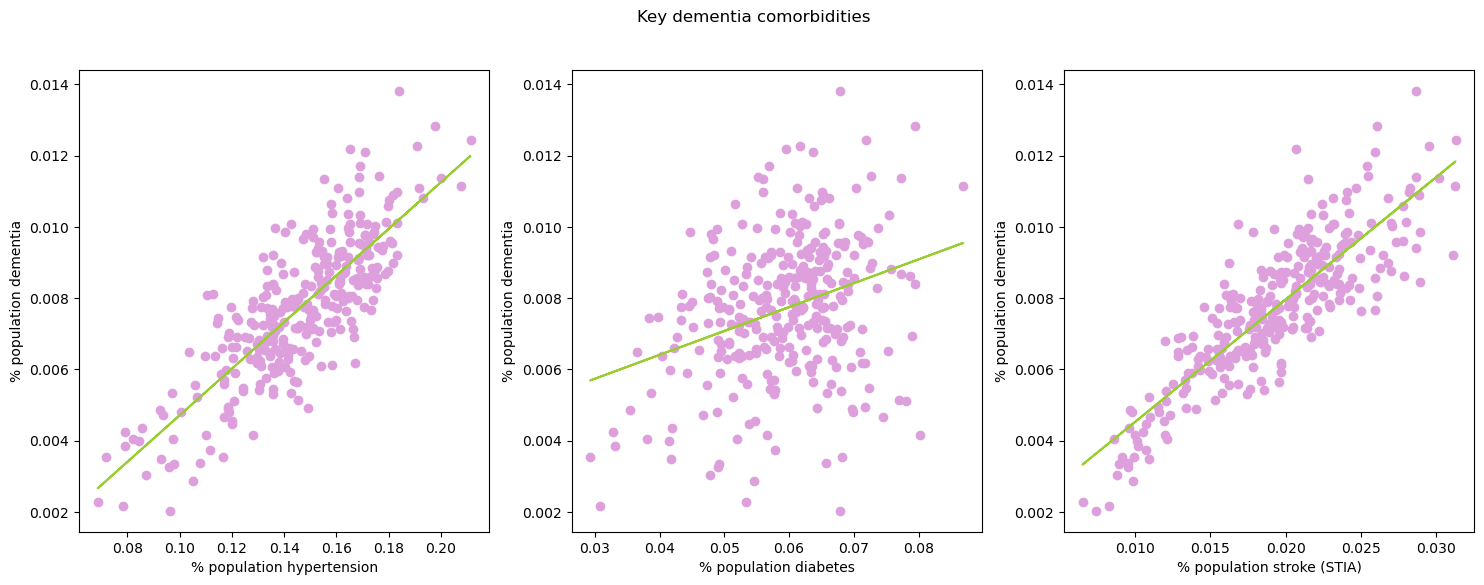

In [55]:
# plot linear regrssion for each comorbiditiy
plt.subplots(nrows=1, ncols= 3, figsize = (18,6))

plt.subplot(1, 3, 1)
plt.scatter(x_hyp, y, color='plum')
plt.plot(x_hyp, y_pred_hyp, color='yellowgreen')
plt.xlabel('% population hypertension')
plt.ylabel('% population dementia')

plt.subplot(1, 3, 2)
plt.scatter(x_dm, y, color='plum')
plt.plot(x_dm, y_pred_dm, color='yellowgreen')
plt.xlabel('% population diabetes')
plt.ylabel('% population dementia')

plt.subplot(1, 3, 3)
plt.scatter(x_stia, y, color='plum')
plt.plot(x_stia, y_pred_stia, color='yellowgreen')
plt.xlabel('% population stroke (STIA)')
plt.ylabel('% population dementia')

plt.suptitle('Key dementia comorbidities')
plt.show()

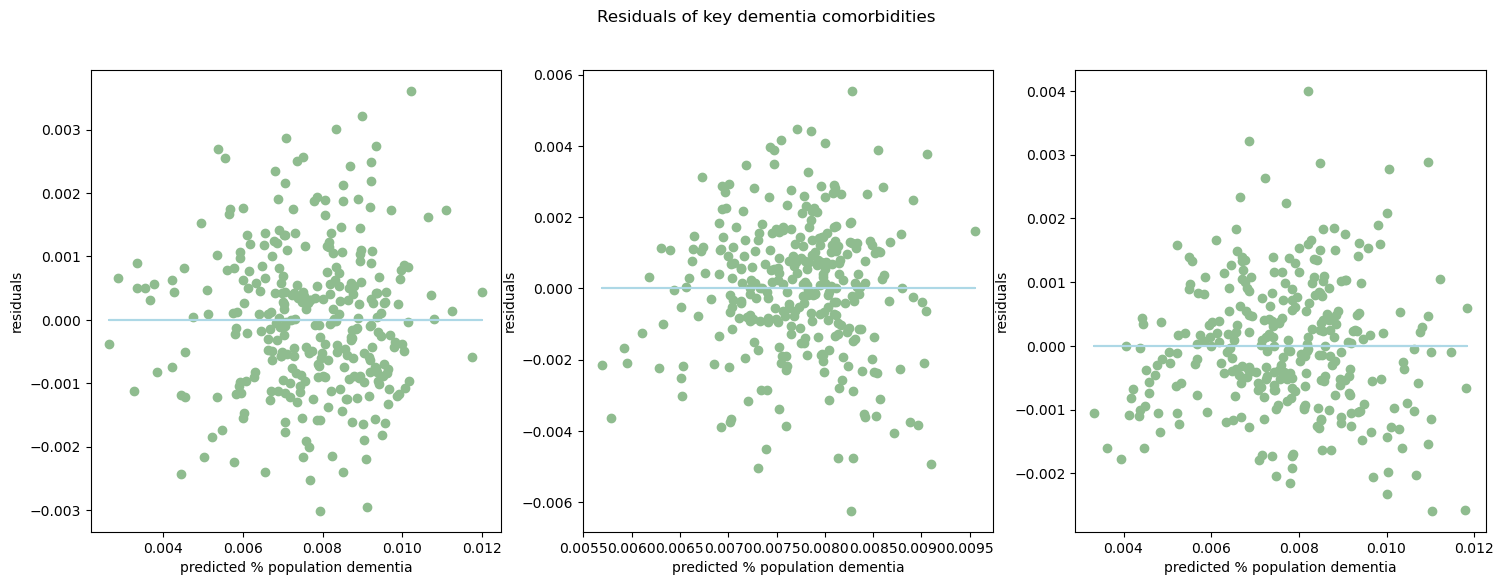

In [56]:
# plot residuals vs predicted values for each comorbiditiy
plt.subplots(nrows=1, ncols= 3, figsize = (18,6))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_hyp, y-y_pred_hyp, color='darkseagreen')
plt.plot(y_pred_hyp, np.zeros(len(y_pred_hyp)), color='lightblue')
plt.xlabel('predicted % population dementia')
plt.ylabel('residuals')

plt.subplot(1, 3, 2)
plt.scatter(y_pred_dm, y-y_pred_dm, color='darkseagreen')
plt.plot(y_pred_dm, np.zeros(len(y_pred_dm)), color='lightblue')
plt.xlabel('predicted % population dementia')
plt.ylabel('residuals')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_stia, y-y_pred_stia, color='darkseagreen')
plt.plot(y_pred_stia, np.zeros(len(y_pred_stia)), color='lightblue')
plt.xlabel('predicted % population dementia')
plt.ylabel('residuals')

plt.suptitle('Residuals of key dementia comorbidities')
plt.show()

When there's multiple variables it's good practise to check for colinearity between them. For this use statsmodels to calculate the variance inflation factor (VIF).

**NOTE** `statsmodels` has the standard parameter that b=0, in y=mx+b so it assumes all linear regressions pass through the origin. You need to add a constant using `add_constant` to fix this. 

In [57]:
# variables 
x_comor_covar = df_dem_covar[['HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']]

# VIF datafram 
comor_vif_data = pd.DataFrame()
comor_vif_data["comor_feature"] = x_comor_covar.columns

# calculate VIF for each factor 
x_comor_covar_const = add_constant(x_comor_covar)
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]


pd.Series([variance_inflation_factor(x_comor_covar_const.values, i)
                          for i in range(x_comor_covar_const.shape[1])],
                          index=x_comor_covar_const.columns)

const              4.105162
HYP_afflicted     65.502495
DM_afflicted      19.785930
STIA_afflicted    23.285511
dtype: float64

So, perhaps as expected, there is high collinearity between the common dementia comorbidities.

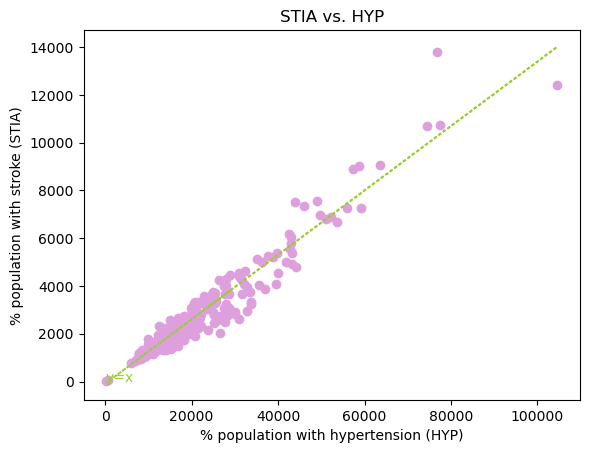

In [64]:
# Comaprison of hypertension and Stroke

x_hyp = df_dem_covar[['HYP_afflicted']].values.reshape(-1,1)
y_stia = df_dem_covar['STIA_afflicted'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_hyp, y_stia)
y_stia_hyp_pred = regr.predict(x_hyp)

# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
plt.plot(x_hyp, y_stia_hyp_pred, ':', color='yellowgreen')
plt.scatter(x_hyp, y_stia, color='plum')
plt.xlabel('% population with hypertension (HYP)')
plt.ylabel('% population with stroke (STIA)')
plt.title('STIA vs. HYP')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.show()

In [59]:
# Multiple linear regression model 
# Using comorbidities to predict dementia diagnosis 

x_mor = df_dem_covar[['HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']].values.reshape(-1,3)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_mor, y)
y_pred_mor = regr.predict(x_mor)

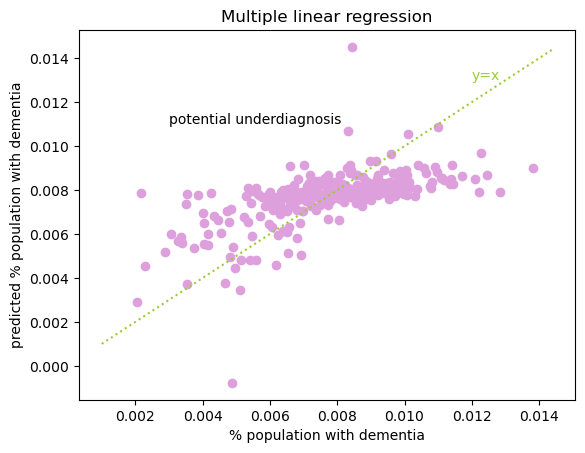

In [60]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(y, y_pred_mor, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression - dementia & comorbidities')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.003, 0.011, r'potential underdiagnosis', fontsize=10)
plt.show()

This figure above is interesting - seems to suggest that the comorbidities aren't very good predictors of dementia (at least at the population level). Need to look at residuals, to check what's going on

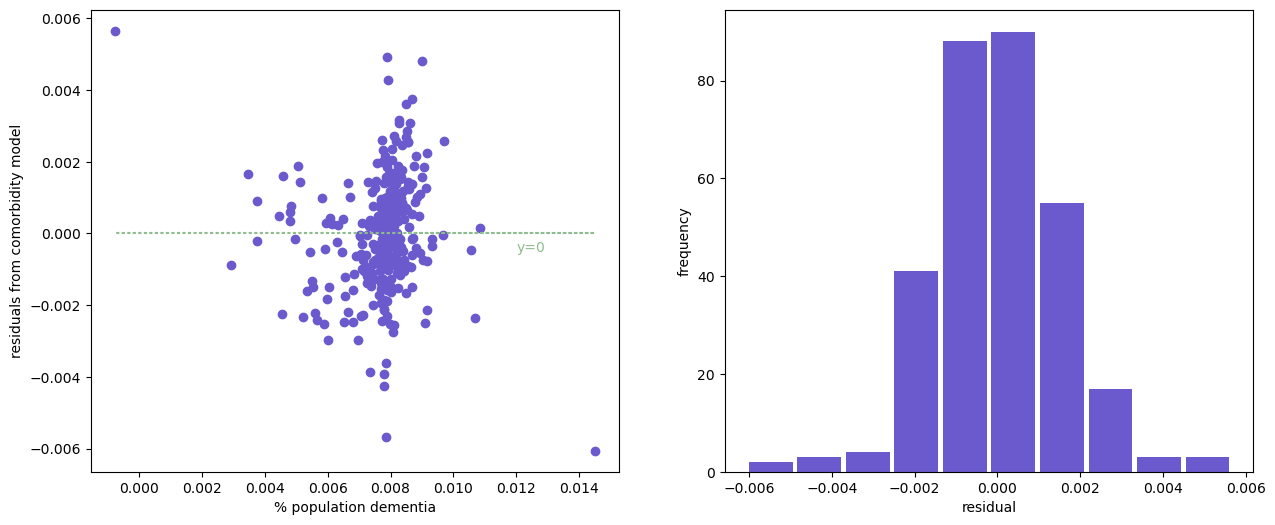

In [61]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

comor_residuals = y-y_pred_mor
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_pred_mor, comor_residuals, color='slateblue')
plt.plot(y_pred_mor, np.zeros(len(y_pred_mor)), ':', color='darkseagreen')
plt.text(0.012, -0.0005, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(comor_residuals, color='slateblue', rwidth=0.9)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

Let's try a log model instead. I'm going to try a level-log regression. 

In [67]:
# Alternative linear regression using sklearn 

x_mor_log = np.log(df_dem_covar[['HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']]).values.reshape(-1,3)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_mor_log, y)
y_pred_mor_log = regr.predict(x_mor_log)

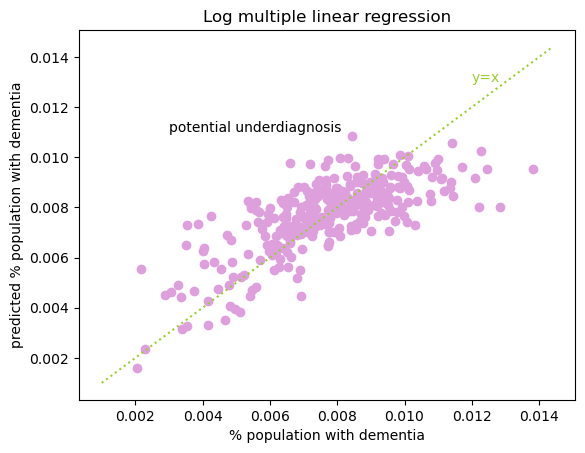

In [68]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(y, y_pred_mor_log, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Log multiple linear regression - dementia & comorbidities')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.003, 0.011, r'potential underdiagnosis', fontsize=10)
plt.show()

Maybe instead I need to look at using a non-linear model - let's try random forest regressor model

In [32]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()

x_mor = df_dem_covar[['HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']].values.reshape(-1,3)

y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

# train the model
clf.fit(x_mor, y)

# predict on test data
rf_predict = clf.predict(x_mor)

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


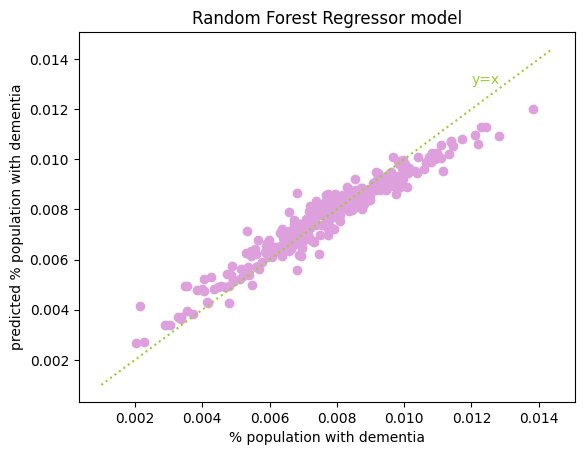

In [33]:
# comparison between true diagnosis value, and the value predicted by the random forest regressor model 
plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(y, rf_predict, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Random Forest Regressor model - dementia & comorbidities')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.008, 0.003, r'potential underdiagnosis', fontsize=10)
plt.show()

Check the collineairty between the covariates I'm interested in.

In [34]:
# variables 
x_all_covar = df_dem_covar[['ALevel_plus_pc', 'white_pc', 'over_65_pc', 'female_pc']]

# VIF datafram 
vif_data = pd.DataFrame()
vif_data["feature"] = x_all_covar.columns

# calculate VIF for each factor 
x_all_covar_const = add_constant(x_all_covar)
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]


pd.Series([variance_inflation_factor(x_all_covar_const.values, i)
                          for i in range(x_all_covar_const.shape[1])],
                          index=x_all_covar_const.columns)

const             579.582663
ALevel_plus_pc      1.229168
white_pc            3.558832
over_65_pc          3.279382
female_pc           1.084889
dtype: float64

The multicollinearity looks fine, so now can do the linear regression.

In [36]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_covar[['ALevel_plus_pc', 'white_pc', 'over_65_pc', 'female_pc']].values.reshape(-1,4)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_all_covar)

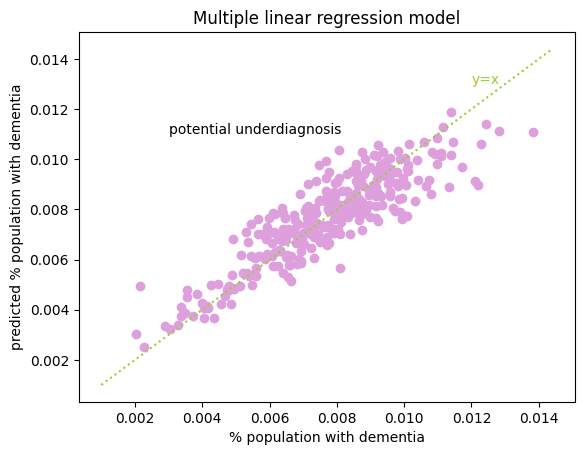

In [37]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(y, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.003, 0.011, r'potential underdiagnosis', fontsize=10)
plt.show()

Check that the model residuals are approximately normally distributed - since this is an assumption of using a linear regression model. 

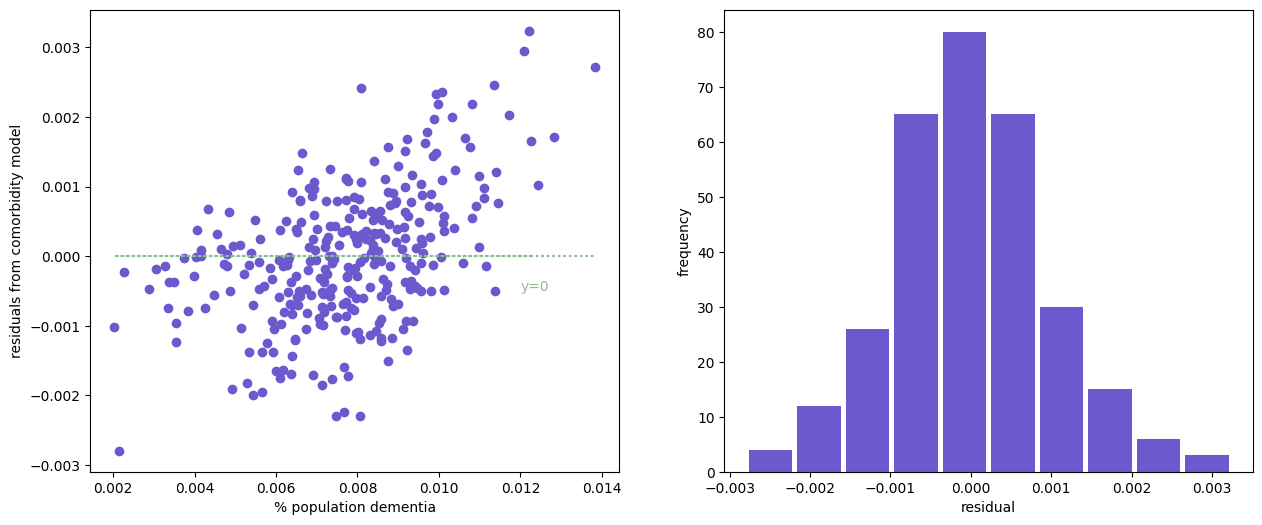

In [38]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

all_var_residuals = y-y_pred_all
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y, all_var_residuals, color='slateblue')
plt.plot(y, np.zeros(len(y)), ':', color='darkseagreen')
plt.text(0.012, -0.0005, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(all_var_residuals, color='slateblue', rwidth=0.9)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

Look at feature importance in the model 

In [39]:
# get importance of each model feature 
feat_coef = regr.coef_
# summarise feature importance
variables = ['Education', 'Ethnicity', 'Age', 'Gender']
for i,v in enumerate(feat_coef.ravel()):
    print(f'Feature: {variables[i]}, Score: {round(float(v), 5)}')

Feature: Education, Score: -0.00139
Feature: Ethnicity, Score: 0.00084
Feature: Age, Score: 0.02684
Feature: Gender, Score: -0.00385
